<a href="https://colab.research.google.com/github/rul124/Capstone-MSED/blob/main/Wav2Vec_Large_Updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import librosa
import librosa.display
from IPython.display import Audio

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

1.12.1+cu113
0.12.1+cu113
cpu


In [4]:
bundle = torchaudio.pipelines.WAV2VEC2_LARGE
model = bundle.get_model().to(device)

print(model.__class__)

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_large_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_large_ls960.pth


  0%|          | 0.00/1.18G [00:00<?, ?B/s]

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [5]:
bundle.sample_rate

16000

### Feature Preparation

In [6]:
# Define path to datasets
DATA_NATURAL = "/content/drive/MyDrive/MESD/MESD_All"
entries = os.listdir(DATA_NATURAL)
print("First:", entries[0])

First: Anger_C_B_alterado.wav


In [7]:
sample_file = DATA_NATURAL + "/" + entries[0]
print("Sample file is:", sample_file)
sample_wave, sr = torchaudio.load(sample_file)
sample_wave = sample_wave.to(device)
if sr != bundle.sample_rate:
    sample_wave = torchaudio.functional.resample(sample_wave, sr, bundle.sample_rate)

with torch.inference_mode():
    features, _ = model.extract_features(sample_wave)

Sample file is: /content/drive/MyDrive/MESD/MESD_All/Anger_C_B_alterado.wav


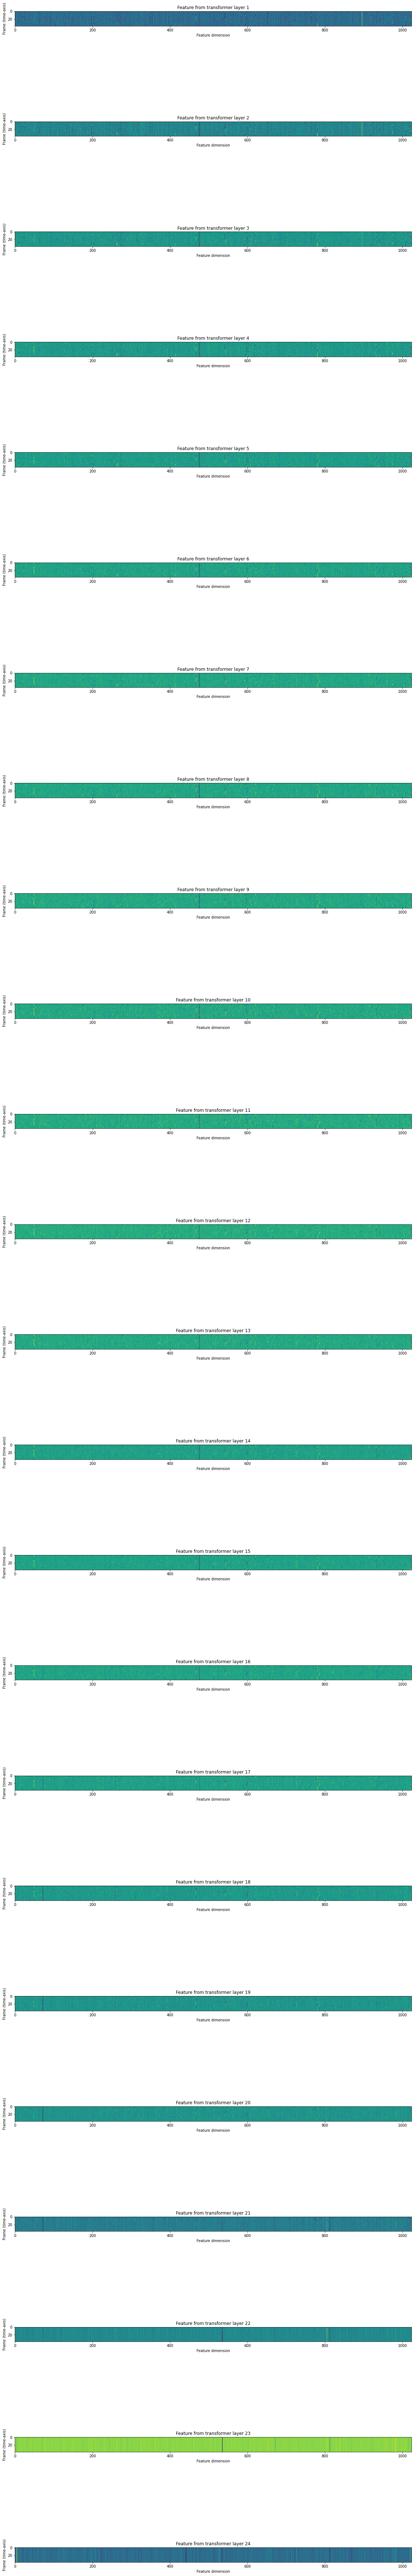

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
plt.tight_layout()
plt.show()

In [9]:
audios_last = []
audios_mean = []
labels = []

from tqdm import tqdm

for i in tqdm(range(len(entries))):
    entry = entries[i]
    path = DATA_NATURAL + "/" + entry
    if "wav" not in path:
      continue
    label = entry.split("_")[0]
    labels.append(label)
    wave, sr = torchaudio.load(path)
    wave = wave.to(device)
    if sr != bundle.sample_rate:
      wave = torchaudio.functional.resample(wave, sr, bundle.sample_rate)
    with torch.inference_mode():
      features, _ = model.extract_features(wave)
    audios_last.append(features[0][0])
    audios_mean.append(torch.mean(torch.stack(features), dim=0)[0])

100%|██████████| 863/863 [10:38<00:00,  1.35it/s]


In [10]:
print("========== Audios - Last ==========")
print(f'First audio_last shape: {audios_last[0].shape}')
print(f'First audio_last size: {audios_last[0].size(0)}')
print(f'Last audio_last torch size: {audios_last[-1].shape}')

print("========== Audios - Mean ==========")
print(f'First audios_mean shape: {audios_mean[0].shape}')
print(f'First audios_mean size: {audios_mean[0].size(0)}')
print(f'Last audios_mean torch size: {audios_mean[-1].shape}')

========== Audios - Last ==========
First audio_last shape: torch.Size([38, 1024])
First audio_last size: 38
Last audio_last torch size: torch.Size([43, 1024])
========== Audios - Mean ==========
First audios_mean shape: torch.Size([38, 1024])
First audios_mean size: 38
Last audios_mean torch size: torch.Size([43, 1024])


In [11]:
# Save audio_last and audio_mean into files
model_path_mean = '/content/drive/MyDrive/MESD/audios_mean_wav2vec_large.pth'

torch.save(audios_mean,
            model_path_mean)

In [12]:
model_path_last = '/content/drive/MyDrive/MESD/audios_last_wav2vec_large.pth'

torch.save(audios_last,
            model_path_last)

In [13]:
class MyDataSet(torch.utils.data.Dataset):
    def __init__(self, data, label, label_transform):
        super(MyDataSet).__init__()
        self.data = data
        self.label = label
        self.label_transform = label_transform
        
    def __getitem__(self, idx):
        audio = self.data[idx]
        label = self.label_transform[self.label[idx]]
        length = self.data[idx].size(0)
        return audio, length, label
    
    def __len__(self):
        return len(self.label)

In [14]:
categories = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Neutral']
cate_dic = {}
for i, cate in enumerate(categories):
    cate_dic[cate] = i
cate_dic

{'Anger': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happiness': 3,
 'Sadness': 4,
 'Neutral': 5}

In [15]:

def collate_indic(data):

    _, lengths, labels = zip(*data)
    max_len = max(lengths)
    n_ftrs = data[0][0].size(1)
    features = torch.zeros((len(data), max_len, n_ftrs))
    labels = torch.tensor(labels)
    lengths = torch.tensor(lengths)

    for i in range(len(data)):
        j, k = data[i][0].size(0), data[i][0].size(1)
        features[i] = torch.cat([data[i][0], torch.zeros((max_len - j, k))])

    return features, lengths, labels

#### Split Data -- Last Layer

In [16]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

X_train, X_test, y_train, y_test = train_test_split(audios_last, labels, 
                                                    test_size=0.2, 
                                                    random_state=4800)

train_dataset = MyDataSet(X_train, y_train, cate_dic)
trainloader_args = dict(batch_size=64, shuffle=True)
train_dataloader = DataLoader(train_dataset, **trainloader_args, 
                              collate_fn=collate_indic)

test_dataset = MyDataSet(X_test, y_test, cate_dic)
testloader_args = dict(batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, **testloader_args, 
                             collate_fn=collate_indic)

In [17]:
for batch, data in enumerate(train_dataloader):
    x, length, y = data
    print(batch, x.shape)

0 torch.Size([64, 109, 1024])
1 torch.Size([64, 102, 1024])
2 torch.Size([64, 116, 1024])
3 torch.Size([64, 92, 1024])
4 torch.Size([64, 111, 1024])
5 torch.Size([64, 92, 1024])
6 torch.Size([64, 100, 1024])
7 torch.Size([64, 107, 1024])
8 torch.Size([64, 98, 1024])
9 torch.Size([64, 126, 1024])
10 torch.Size([49, 70, 1024])


#### Split Data -- Mean of Layers

In [18]:
X_train_mean, X_test_mean, y_train_mean, y_test_mean = train_test_split(audios_mean, labels, 
                                                    test_size=0.2, 
                                                    random_state=4800)

train_dataset_mean = MyDataSet(X_train_mean, y_train_mean, cate_dic)
trainloader_args_mean = dict(batch_size=64, shuffle=True)
train_dataloader_mean = DataLoader(train_dataset_mean, **trainloader_args_mean, 
                              collate_fn=collate_indic)

test_dataset_mean = MyDataSet(X_test_mean, y_test_mean, cate_dic)
testloader_args_mean = dict(batch_size=1, shuffle=True)
test_dataloader_mean = DataLoader(test_dataset_mean, **testloader_args_mean, 
                             collate_fn=collate_indic)

for batch, data in enumerate(train_dataloader_mean):
    x, length, y = data
    print(batch, x.shape)

0 torch.Size([64, 116, 1024])
1 torch.Size([64, 126, 1024])
2 torch.Size([64, 111, 1024])
3 torch.Size([64, 108, 1024])
4 torch.Size([64, 91, 1024])
5 torch.Size([64, 92, 1024])
6 torch.Size([64, 92, 1024])
7 torch.Size([64, 92, 1024])
8 torch.Size([64, 66, 1024])
9 torch.Size([64, 100, 1024])
10 torch.Size([49, 63, 1024])


### Data Visualization -- TSNE

In [20]:
audios_last = [torch.mean(audio, dim=0).tolist() for audio in audios_last]
len(audios_last)

862

In [21]:
len(audios_last[0])

1024

In [22]:
audios_mean = [torch.mean(audio, dim=0).tolist() for audio in audios_mean]
len(audios_mean)

862

In [23]:
num_to_cate = {'Anger': 'angry',
 'Happiness': 'happy',
 'Sadness': 'sad',
 'Neutral': 'neutral'}

cate_audios_last = []
cate_audios_mean = []
cate_labels = []

for i in range(len(audios_last)):
  if labels[i] in num_to_cate:
    cate_audios_last.append(audios_last[i])
    cate_audios_mean.append(audios_mean[i])
    cate_labels.append(num_to_cate[labels[i]])

#### Data Visualization -- Last Layer

In [24]:
from sklearn.manifold import TSNE

tsne_last = TSNE(n_components=2, random_state=4800, perplexity=20)
output_last = tsne_last.fit_transform(cate_audios_last)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


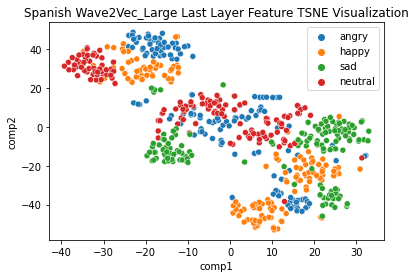

In [25]:
import seaborn as sns
import pandas as pd

df_last = pd.DataFrame(output_last, columns=['comp1', 'comp2'])
sns.scatterplot(x='comp1', y='comp2', hue=cate_labels, data=df_last).set(title='Spanish Wave2Vec_Large Last Layer Feature TSNE Visualization')
plt.show()

#### Data Visualization -- Mean of Layers

In [26]:
tsne_mean = TSNE(n_components=2, random_state=4800, perplexity=20)
output_mean = tsne_mean.fit_transform(cate_audios_mean)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


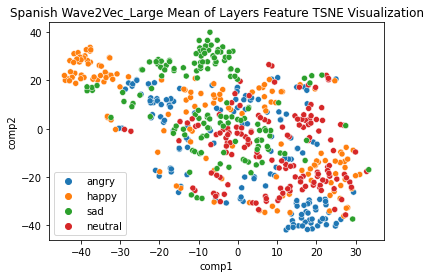

In [27]:
df_mean = pd.DataFrame(output_mean, columns=['comp1', 'comp2'])
sns.scatterplot(x='comp1', 
                y='comp2', 
                hue=cate_labels, 
                data=df_mean).set(
                    title='Spanish Wave2Vec_Large Mean of Layers Feature TSNE Visualization'
                    )
plt.show()

## CNN Model Training

In [28]:
import torch.nn as nn
import torch.nn.functional as F

class ICASSP3CNN(nn.Module):
    def __init__(self, vocab_size, embed_size=128, hidden_size=512, num_lstm_layers = 2, bidirectional = False, label_size=7):
        super().__init__()
        self.n_layers = num_lstm_layers 
        self.hidden = hidden_size
        self.bidirectional = bidirectional
        
        self.embed = nn.Linear(in_features = vocab_size, out_features = embed_size)

        self.cnn  = nn.Conv1d(embed_size, embed_size, kernel_size=3, padding=1)
        self.cnn2 = nn.Conv1d(embed_size, embed_size, kernel_size=5, padding=2)
        self.cnn3 = nn.Conv1d(embed_size, embed_size, kernel_size=7, padding=3)

        self.batchnorm = nn.BatchNorm1d(3 * embed_size)

        self.lstm = nn.LSTM(input_size = 3 * embed_size, 
                            hidden_size = hidden_size, 
                            num_layers = num_lstm_layers, 
                            bidirectional = bidirectional)

        self.linear = nn.Linear(in_features = 2 * hidden_size if bidirectional else hidden_size, 
                                out_features = label_size)


    def forward(self, x, lengths):
        """
        padded_x: (B,T) padded LongTensor
        """

        input = self.embed(x)

        batch_size = input.size(0)
        input = input.transpose(1,2)    # (B,T,H) -> (B,H,T)

        cnn_output = torch.cat([self.cnn(input), self.cnn2(input), self.cnn3(input)], dim=1)

        input = F.relu(self.batchnorm(cnn_output))

        input = input.transpose(1,2)

        pack_tensor = nn.utils.rnn.pack_padded_sequence(input, lengths, batch_first=True, enforce_sorted=False)
        _, (hn, cn) = self.lstm(pack_tensor)

        if self.bidirectional:
            h_n = hn.view(self.n_layers, 2, batch_size, self.hidden)
            h_n = torch.cat([ h_n[-1, 0,:], h_n[-1,1,:] ], dim = 1)
        else:
            h_n = hn[-1]

        logits = self.linear(h_n)

        return logits

In [32]:
from torchsummary import summary

model_mean = ICASSP3CNN(1024)
model_last = ICASSP3CNN(1024)

In [33]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

#### Last Layer Model Training

In [ ]:
from tqdm import tqdm

epochs = 30
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

for epoch in tqdm(range(epochs)):
    train_loss = 0
    acc_cnt = 0
    err_cnt = 0
    batch_cnt = 0
    model_last.train()
    for batch, (x, length, y) in enumerate(train_dataloader):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        logits = model_last(x, length)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.cpu().item()

        #model_last outputs
        out_val, out_indices = torch.max(logits, dim=1)
        tar_indices = y

        for i in range(len(out_indices)):
            if out_indices[i] == tar_indices[i]:
                acc_cnt += 1
            else:
                err_cnt += 1
        batch_cnt += 1
    
    train_loss = train_loss/batch_cnt
    train_accuracy = acc_cnt/(acc_cnt+err_cnt)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)

    valid_loss = 0
    acc_cnt = 0
    err_cnt = 0
    batch_cnt = 0
    model_last.eval()

    for x, lengths, y in test_dataloader:

        x = x.to(device)
        y = y.to(device)

        logits = model_last(x, lengths)
        loss = criterion(logits, y)
        valid_loss += loss.cpu().item()

        out_val, out_indices = torch.max(logits, dim=1)
        tar_indices = y

        for i in range(len(out_indices)):
            if out_indices[i] == tar_indices[i]:
                acc_cnt += 1
            else:
                err_cnt += 1
        batch_cnt += 1
    
    valid_loss = valid_loss/batch_cnt
    valid_accuracy = acc_cnt/(acc_cnt+err_cnt)
    valid_accuracies.append(valid_accuracy)
    valid_losses.append(valid_loss)

    print(f"epoch:{epoch+1}, train accu:{train_accuracy:.4f}," + 
          f"train loss:{train_loss:.2f}, valid accu:{valid_accuracy:.4f}" + 
          f" valid loss:{valid_loss:.2f}")

  3%|▎         | 1/30 [00:56<27:08, 56.14s/it]

epoch:1, train accu:0.1582,train loss:1.95, valid accu:0.1561 valid loss:1.95


  7%|▋         | 2/30 [01:49<25:18, 54.24s/it]

epoch:2, train accu:0.1597,train loss:1.95, valid accu:0.1561 valid loss:1.95


 10%|█         | 3/30 [02:42<24:16, 53.96s/it]

epoch:3, train accu:0.1611,train loss:1.95, valid accu:0.1561 valid loss:1.95


 13%|█▎        | 4/30 [03:36<23:19, 53.84s/it]

epoch:4, train accu:0.1611,train loss:1.95, valid accu:0.1561 valid loss:1.95


 17%|█▋        | 5/30 [04:31<22:41, 54.45s/it]

epoch:5, train accu:0.1597,train loss:1.95, valid accu:0.1561 valid loss:1.95


 20%|██        | 6/30 [05:28<22:02, 55.12s/it]

epoch:6, train accu:0.1597,train loss:1.95, valid accu:0.1503 valid loss:1.95


 23%|██▎       | 7/30 [06:23<21:07, 55.11s/it]

epoch:7, train accu:0.1611,train loss:1.95, valid accu:0.1503 valid loss:1.95


 27%|██▋       | 8/30 [07:17<20:02, 54.67s/it]

epoch:8, train accu:0.1597,train loss:1.95, valid accu:0.1503 valid loss:1.95


 30%|███       | 9/30 [08:14<19:28, 55.64s/it]

epoch:9, train accu:0.1582,train loss:1.95, valid accu:0.1503 valid loss:1.95


 33%|███▎      | 10/30 [09:09<18:27, 55.38s/it]

epoch:10, train accu:0.1611,train loss:1.95, valid accu:0.1503 valid loss:1.95


 37%|███▋      | 11/30 [10:02<17:18, 54.65s/it]

epoch:11, train accu:0.1626,train loss:1.95, valid accu:0.1503 valid loss:1.95


 40%|████      | 12/30 [10:57<16:25, 54.73s/it]

epoch:12, train accu:0.1582,train loss:1.95, valid accu:0.1503 valid loss:1.95


 43%|████▎     | 13/30 [11:51<15:25, 54.46s/it]

epoch:13, train accu:0.1597,train loss:1.95, valid accu:0.1503 valid loss:1.95


 47%|████▋     | 14/30 [12:48<14:41, 55.11s/it]

epoch:14, train accu:0.1611,train loss:1.95, valid accu:0.1503 valid loss:1.95


 50%|█████     | 15/30 [13:41<13:41, 54.75s/it]

epoch:15, train accu:0.1597,train loss:1.95, valid accu:0.1503 valid loss:1.95


 53%|█████▎    | 16/30 [14:35<12:42, 54.49s/it]

epoch:16, train accu:0.1597,train loss:1.95, valid accu:0.1503 valid loss:1.95


 57%|█████▋    | 17/30 [15:31<11:53, 54.92s/it]

epoch:17, train accu:0.1611,train loss:1.95, valid accu:0.1503 valid loss:1.95


 60%|██████    | 18/30 [16:24<10:52, 54.39s/it]

epoch:18, train accu:0.1611,train loss:1.95, valid accu:0.1503 valid loss:1.95


 63%|██████▎   | 19/30 [17:18<09:57, 54.29s/it]

epoch:19, train accu:0.1611,train loss:1.95, valid accu:0.1503 valid loss:1.95


 67%|██████▋   | 20/30 [18:14<09:05, 54.58s/it]

epoch:20, train accu:0.1597,train loss:1.95, valid accu:0.1503 valid loss:1.95


 70%|███████   | 21/30 [19:09<08:11, 54.66s/it]

epoch:21, train accu:0.1597,train loss:1.95, valid accu:0.1503 valid loss:1.95


 73%|███████▎  | 22/30 [20:01<07:10, 53.86s/it]

epoch:22, train accu:0.1597,train loss:1.95, valid accu:0.1503 valid loss:1.95


 77%|███████▋  | 23/30 [20:52<06:12, 53.22s/it]

epoch:23, train accu:0.1582,train loss:1.95, valid accu:0.1503 valid loss:1.95


 80%|████████  | 24/30 [21:47<05:22, 53.81s/it]

epoch:24, train accu:0.1582,train loss:1.95, valid accu:0.1503 valid loss:1.95


 83%|████████▎ | 25/30 [22:42<04:29, 53.90s/it]

epoch:25, train accu:0.1597,train loss:1.95, valid accu:0.1503 valid loss:1.95


 87%|████████▋ | 26/30 [23:37<03:37, 54.50s/it]

epoch:26, train accu:0.1567,train loss:1.95, valid accu:0.1503 valid loss:1.95


In [ ]:
model_path_last = '/content/drive/MyDrive/MESD/wav2vec_large_last.pth'

torch.save({'epoch':length,
            'model_state_dict':model_last.state_dict(),
            'optimizer_state_dict':optimizer.state_dict()},
            model_path_last)

In [ ]:
import matplotlib.pyplot as plt
length = len(train_losses)
plt.plot(range(length), train_losses, label='train')
plt.plot(range(length), valid_losses, label='valid')
plt.legend()
plt.title('training and validation loss -- Wav2Vec Large w/ Last Layer')
plt.show()

In [ ]:
plt.plot(range(length), train_accuracies, label='train')
plt.plot(range(length), valid_accuracies, label='valid')
plt.legend()
plt.title('training and validation accuracy -- Wav2Vec Large w/ Last Layer')
plt.show()

In [ ]:
import pandas as pd
from datetime import datetime

now = datetime.now()

metadata = pd.DataFrame({'epoch':range(length), 'train loss':train_losses, 
                         'valid loss':valid_losses, 
                         'train accu':train_accuracies, 
                         'valid_accu':valid_accuracies})
metadata.to_csv(f'/content/drive/MyDrive/MESD/wav2vec_large_last.csv', index=False)

#### Mean of Layers Model Training

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

for epoch in tqdm(range(epochs)):
    train_loss = 0
    acc_cnt = 0
    err_cnt = 0
    batch_cnt = 0
    model_mean.train()
    for batch, (x, length, y) in enumerate(train_dataloader_mean):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        logits = model_mean(x, length)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.cpu().item()

        #model_mean outputs
        out_val, out_indices = torch.max(logits, dim=1)
        tar_indices = y

        for i in range(len(out_indices)):
            if out_indices[i] == tar_indices[i]:
                acc_cnt += 1
            else:
                err_cnt += 1
        batch_cnt += 1
    
    train_loss = train_loss/batch_cnt
    train_accuracy = acc_cnt/(acc_cnt+err_cnt)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)

    valid_loss = 0
    acc_cnt = 0
    err_cnt = 0
    batch_cnt = 0
    model_mean.eval()

    for x, lengths, y in test_dataloader_mean:

        x = x.to(device)
        y = y.to(device)

        logits = model_mean(x, lengths)
        loss = criterion(logits, y)
        valid_loss += loss.cpu().item()

        out_val, out_indices = torch.max(logits, dim=1)
        tar_indices = y

        for i in range(len(out_indices)):
            if out_indices[i] == tar_indices[i]:
                acc_cnt += 1
            else:
                err_cnt += 1
        batch_cnt += 1
    
    valid_loss = valid_loss/batch_cnt
    valid_accuracy = acc_cnt/(acc_cnt+err_cnt)
    valid_accuracies.append(valid_accuracy)
    valid_losses.append(valid_loss)

    print(f"epoch:{epoch+1}, train accu:{train_accuracy:.4f}," + 
          f"train loss:{train_loss:.2f}, valid accu:{valid_accuracy:.4f}" + 
          f" valid loss:{valid_loss:.2f}")

  3%|▎         | 1/30 [00:54<26:15, 54.34s/it]

epoch:1, train accu:0.2003,train loss:1.94, valid accu:0.1676 valid loss:1.95


  7%|▋         | 2/30 [01:51<26:00, 55.72s/it]

epoch:2, train accu:0.2003,train loss:1.94, valid accu:0.1908 valid loss:1.95


 10%|█         | 3/30 [02:47<25:12, 56.01s/it]

epoch:3, train accu:0.2003,train loss:1.94, valid accu:0.1908 valid loss:1.95


 13%|█▎        | 4/30 [03:43<24:19, 56.13s/it]

epoch:4, train accu:0.2046,train loss:1.94, valid accu:0.2139 valid loss:1.94


 17%|█▋        | 5/30 [04:36<22:51, 54.85s/it]

epoch:5, train accu:0.2090,train loss:1.94, valid accu:0.2486 valid loss:1.94


 20%|██        | 6/30 [05:31<21:57, 54.90s/it]

epoch:6, train accu:0.1988,train loss:1.94, valid accu:0.2312 valid loss:1.94


 23%|██▎       | 7/30 [06:23<20:44, 54.12s/it]

epoch:7, train accu:0.2003,train loss:1.94, valid accu:0.2428 valid loss:1.94


 27%|██▋       | 8/30 [07:18<19:56, 54.40s/it]

epoch:8, train accu:0.1988,train loss:1.94, valid accu:0.2486 valid loss:1.94


 30%|███       | 9/30 [08:11<18:49, 53.78s/it]

epoch:9, train accu:0.1945,train loss:1.94, valid accu:0.2486 valid loss:1.94


 33%|███▎      | 10/30 [09:08<18:17, 54.86s/it]

epoch:10, train accu:0.2061,train loss:1.94, valid accu:0.2486 valid loss:1.94


 37%|███▋      | 11/30 [10:04<17:26, 55.08s/it]

epoch:11, train accu:0.2090,train loss:1.94, valid accu:0.2543 valid loss:1.94


 40%|████      | 12/30 [10:58<16:29, 54.97s/it]

epoch:12, train accu:0.2061,train loss:1.94, valid accu:0.2543 valid loss:1.94


 43%|████▎     | 13/30 [11:51<15:21, 54.20s/it]

epoch:13, train accu:0.2061,train loss:1.94, valid accu:0.2486 valid loss:1.94


 47%|████▋     | 14/30 [12:49<14:46, 55.39s/it]

epoch:14, train accu:0.2003,train loss:1.94, valid accu:0.2543 valid loss:1.94


 50%|█████     | 15/30 [13:46<13:56, 55.78s/it]

epoch:15, train accu:0.2017,train loss:1.94, valid accu:0.2601 valid loss:1.94


 53%|█████▎    | 16/30 [14:41<13:00, 55.78s/it]

epoch:16, train accu:0.1959,train loss:1.94, valid accu:0.2543 valid loss:1.94


 57%|█████▋    | 17/30 [15:36<12:01, 55.47s/it]

epoch:17, train accu:0.2061,train loss:1.94, valid accu:0.2486 valid loss:1.94


 60%|██████    | 18/30 [16:31<11:01, 55.16s/it]

epoch:18, train accu:0.2104,train loss:1.94, valid accu:0.2543 valid loss:1.94


 63%|██████▎   | 19/30 [17:24<10:02, 54.74s/it]

epoch:19, train accu:0.2061,train loss:1.94, valid accu:0.2486 valid loss:1.94


 67%|██████▋   | 20/30 [18:19<09:06, 54.65s/it]

epoch:20, train accu:0.2046,train loss:1.94, valid accu:0.2543 valid loss:1.94


 70%|███████   | 21/30 [19:15<08:17, 55.28s/it]

epoch:21, train accu:0.2061,train loss:1.94, valid accu:0.2486 valid loss:1.94


 73%|███████▎  | 22/30 [20:10<07:21, 55.16s/it]

epoch:22, train accu:0.2061,train loss:1.94, valid accu:0.2486 valid loss:1.94


 77%|███████▋  | 23/30 [21:05<06:24, 54.96s/it]

epoch:23, train accu:0.2061,train loss:1.94, valid accu:0.2543 valid loss:1.94


 80%|████████  | 24/30 [22:00<05:30, 55.02s/it]

epoch:24, train accu:0.2061,train loss:1.94, valid accu:0.2543 valid loss:1.94


 83%|████████▎ | 25/30 [22:56<04:36, 55.36s/it]

epoch:25, train accu:0.2017,train loss:1.94, valid accu:0.2543 valid loss:1.94


 87%|████████▋ | 26/30 [23:52<03:41, 55.41s/it]

epoch:26, train accu:0.2017,train loss:1.94, valid accu:0.2543 valid loss:1.94


 90%|█████████ | 27/30 [24:49<02:47, 55.84s/it]

epoch:27, train accu:0.2075,train loss:1.94, valid accu:0.2543 valid loss:1.94


 93%|█████████▎| 28/30 [25:44<01:51, 55.87s/it]

epoch:28, train accu:0.1974,train loss:1.94, valid accu:0.2543 valid loss:1.94


 97%|█████████▋| 29/30 [26:38<00:55, 55.08s/it]

epoch:29, train accu:0.2017,train loss:1.94, valid accu:0.2486 valid loss:1.94


100%|██████████| 30/30 [27:33<00:00, 55.12s/it]

epoch:30, train accu:0.1974,train loss:1.94, valid accu:0.2543 valid loss:1.94


In [40]:
model_path_mean = '/content/drive/MyDrive/MESD/wav2vec_large_mean.pth'
length = len(train_losses)
torch.save({'epoch':length,
            'model_state_dict':model_mean.state_dict(),
            'optimizer_state_dict':optimizer.state_dict()},
            model_path_mean)

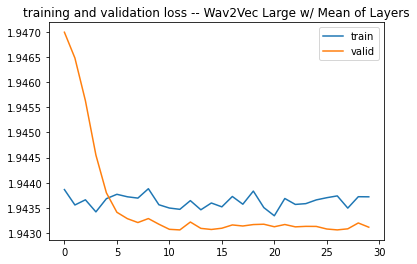

In [41]:
plt.plot(range(length), train_losses, label='train')
plt.plot(range(length), valid_losses, label='valid')
plt.legend()
plt.title('training and validation loss -- Wav2Vec Large w/ Mean of Layers')
plt.show()

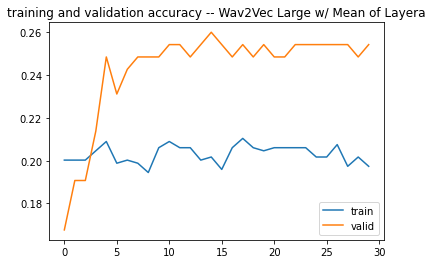

In [42]:
plt.plot(range(length), train_accuracies, label='train')
plt.plot(range(length), valid_accuracies, label='valid')
plt.legend()
plt.title('training and validation accuracy -- Wav2Vec Large w/ Mean of Layera')
plt.show()

In [43]:
now = datetime.now()

metadata = pd.DataFrame({'epoch':range(length), 'train loss':train_losses, 
                         'valid loss':valid_losses, 
                         'train accu':train_accuracies, 
                         'valid_accu':valid_accuracies})
metadata.to_csv(f'/content/drive/MyDrive/MESD/wav2vec_large_mean.csv', index=False)